In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import time
import numpy as np
import pickle

from sklearn.manifold import TSNE
from nltk.tokenize import sent_tokenize
# from flair.embeddings import WordEmbeddings
# from flair.data import Sentence
from eventepi.pipeline import RecommenderLabeling

In [5]:
X_transform = np.loadtxt('X_embed.csv', delimiter=',')

# Glove Embeddings

In [12]:
df = RecommenderLabeling().data_output()
X = df['extracted_text']
y = df['label']

# init embedding
glove_embedding = WordEmbeddings('en-news')
# preprocess to flair Sentence
sentences = [Sentence(sentence) for sentence in sent_tokenize(' '.join(X))]

# embed a sentence using glove.
for sentence in sentences:
    glove_embedding.embed(sentence)

In [17]:
words = []
embeddings = []
for sentence in sentences:
    for token in sentence:
        if not len(token.text)>12 and all(c.isalnum() for c in token.text) and sum(token.embedding)>1:
            words.append(token.text)
            embeddings.append(token.embedding.numpy())

In [43]:
with open("glove_trained_embeddings.pkl", "wb") as f:
    pickle.dump(list(zip(words,embeddings)), f)

In [6]:
with open("glove_trained_embeddings.pkl", "rb") as f:
    word_and_embeddings = pickle.load(f)

In [10]:
words, embeddings = map(list,zip(*word_and_embeddings))

In [14]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings[::1000])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 211 samples in 0.002s...
[t-SNE] Computed neighbors for 211 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 0.860417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.240685
[t-SNE] KL divergence after 1000 iterations: 0.518517


In [15]:
d = dict(zip(words, embeddings))

In [16]:
words_ = [k for k, _ in d.items()]
embeddings_ = [v for _, v in d.items()]

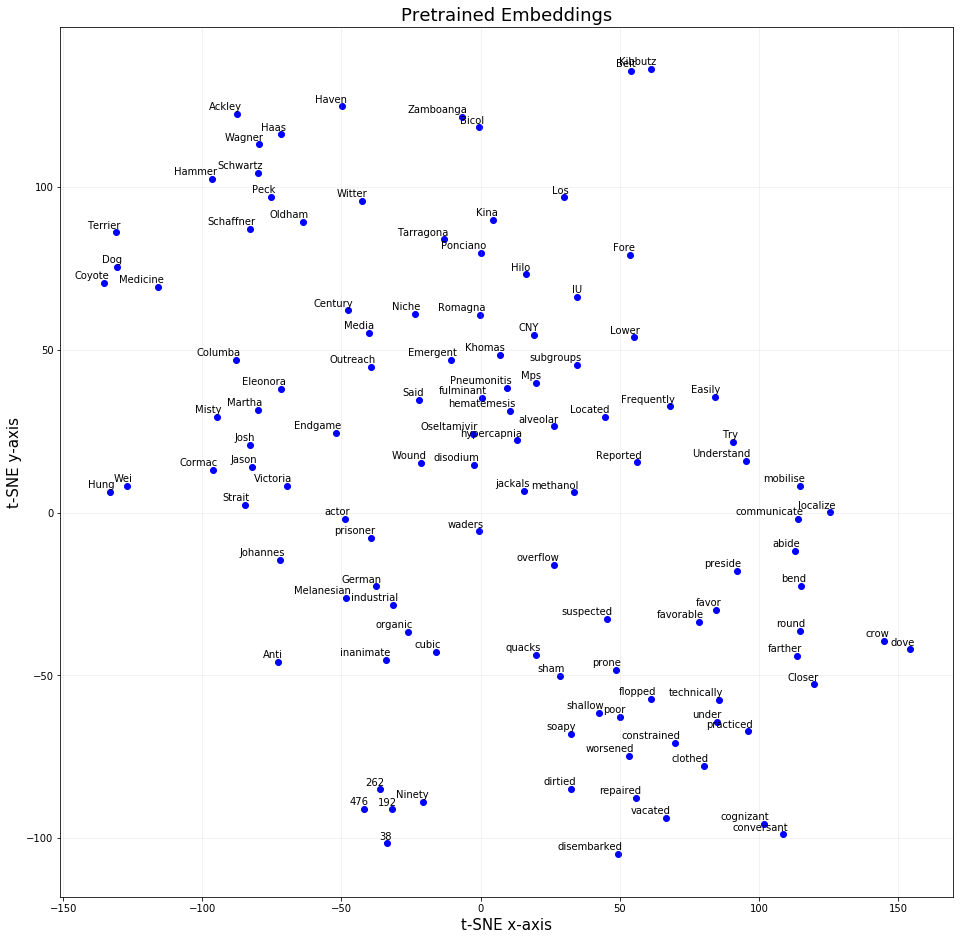

In [17]:
"Creates and TSNE model and plots it"
labels = words_[6::50]
values = embeddings_[6::50]


tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=12)
new_values = tsne_model.fit_transform(values)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i], c="blue")
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.xlabel("t-SNE x-axis", size=15)
plt.ylabel("t-SNE y-axis", size=15)
plt.grid(alpha=0.2)
plt.title("Pretrained Embeddings", size=18)
plt.savefig("t-sne_pre.pdf",format='pdf')
plt.show()
plt.show()

# Self-trained embeddings

In [20]:
import multiprocessing
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
import re
import nltk
import matplotlib.cm as cm
import codecs

def train_word2vec(filename):
    data = gensim.models.word2vec.LineSentence(filename)
    return Word2Vec(data, size=100, window=1, min_count=5, workers=multiprocessing.cpu_count())

def prepare_for_w2v(filename_from, filename_to):
    raw_text = codecs.open(filename_from, "r").read()
    with open(filename_to, 'w', encoding='utf-8') as f:
        for sentence in nltk.sent_tokenize(raw_text):
            print(sentence.lower(), file=f)

In [24]:
prepare_for_w2v('extracted.txt', 'extracted_sentences.txt')

In [25]:
model_extracted_sentences = train_word2vec('extracted_sentences.txt')

2019-04-19 13:12:44,532 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:46,119 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:48,502 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:50,727 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:52,892 this function is deprecated, use smart_open.open instead
2019-04-19 13:12:55,026 this function is deprecated, use smart_open.open instead


In [26]:
words_self = []
embeddings_self = []
for word in list(model_extracted_sentences.wv.vocab):
    if word.isalnum() and len(word) < 12:
        embeddings_self.append(model_extracted_sentences.wv[word])
        words_self.append(word)

In [29]:
words_self_ = words_self[5::70]
embeddings_self_ = embeddings_self[5::70]

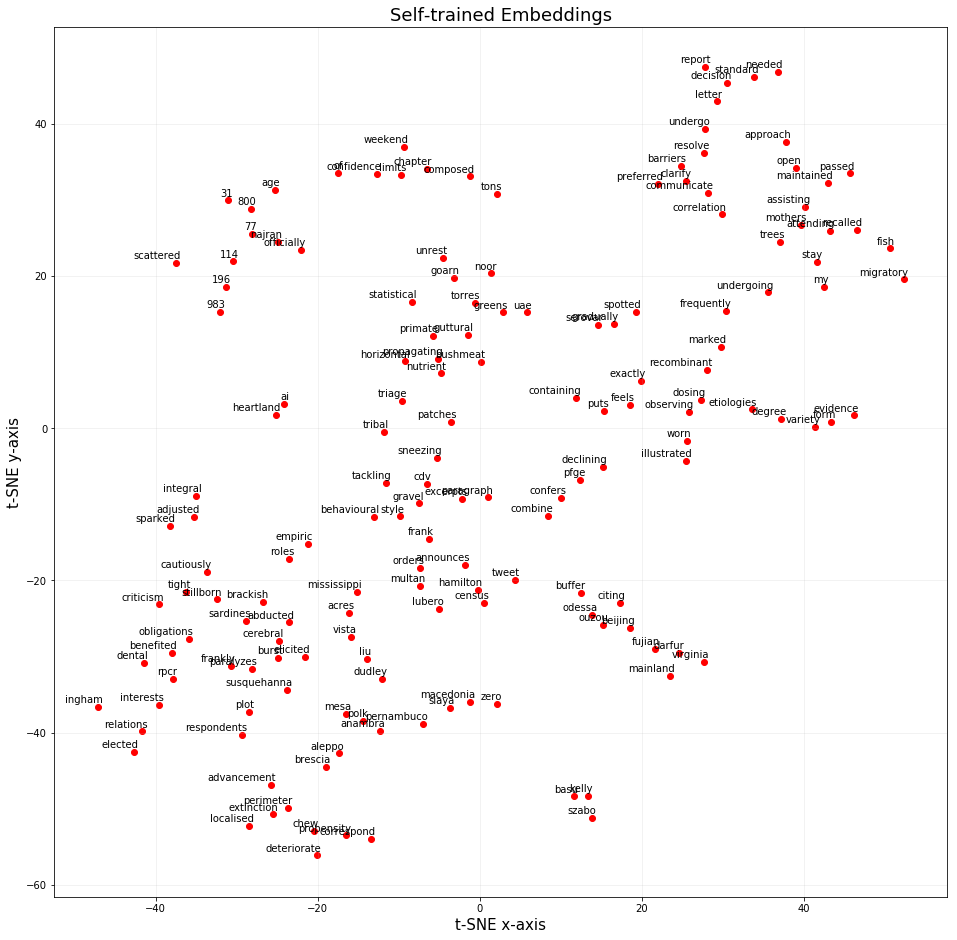

In [30]:
tsne_model_self = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=12)
new_values_self = tsne_model.fit_transform(embeddings_self_)

x_self = []
y_self = []
for value in new_values_self:
    x_self.append(value[0])
    y_self.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x_self)):
    dot = plt.scatter(x_self[i],y_self[i], c="red")
    plt.annotate(words_self_[i],
                 xy=(x_self[i], y_self[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.xlabel("t-SNE x-axis", size=15)
plt.ylabel("t-SNE y-axis", size=15)
plt.grid(alpha=0.2)


plt.title("Self-trained Embeddings", size=18)
plt.savefig("t-sne_self.pdf",format='pdf')
plt.show()

# Hybrid word vectors

In [22]:
from gensim.models import KeyedVectors
import pandas as pd
from nltk import word_tokenize

In [14]:
kv = KeyedVectors.load("wiki_self_embeddings100", mmap='r')

c:\users\abbooda\appdata\local\continuum\anaconda3\envs\rki\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [20]:
df = pd.read_csv("with_label.csv")

In [21]:
X = df["extracted_text"]

In [26]:
"a".isalnum()

True

In [28]:
embeddings = []
words = []
for word in word_tokenize(" ".join(X.tolist())):
    if word.isalnum() and len(word) < 12:
        try:
            embeddings.append(kv[word.lower()])
        except KeyError:
            print(word)
        words.append(word.lower())

c:\users\abbooda\appdata\local\continuum\anaconda3\envs\rki\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Update28
543
news28
115kbFrom
806
news27
RDSRU
PDSRU
responseIn
GARDP
Update20
Mutawanga
501
193
On19
Update13
296
Update6
458
Update29
2018As
Kalungunta
Kalungunta
375
242
Update22
provisision
114kbFrom
Update15
2018New
Update8
2018As
5430
9106
7256
Butsili
458
389
news1
115kbFrom
2262
Update1
surivors
5813
8916
6578
3345
328
hled
vacicine
news30
Update25
5723
8471
5488
3345
9955
Tschomia
Update18
Kalungata
4798
7134
4495
2133
3115
807
1709
Livolo
SSHAP
news15
Swakin
Gadaref
Gadaref
news11
2732
October2
6327
3439
ECCARN
Update5
4914
8535
8535
8341
8340
responseOn
3800
IACCH
Update5
4km
3692
Guidam
Mabalza
BEFEN
news5
269
news4
1900
5678
2915
233
PHEOC
PHEOC
ECCARN
news3
13kbFrom
2254
news27
1660
September2
5041
2497
activities3
September2
701
4008
2362
3621
3564
adviceFor
2018Six
5500
8902
2951
2054
news12
2249
news7
2018Event
Bissongo
Bissongo
news7
20181
2265
6830
1746
1762
642
news5
deaths1
three2
available4
news31
1865
795
news31
2444
5130
1340
GS5734
remdisivir
reported1
countrie

20blood
20donations
201803406
Douam
NS2B3
NS2B3
1538
655
683
VACHCS
VACHCS
e0006594
2057
1793
562
rendorcée
Baojialu
2410
4135
Marasini
831
1435
Marasini
831
1435
GZAR
HA0
H6N6
EV70
A24
CVA24v
EV70
CVA24v
Strausss
A24
1964
655
4436
1355
Vallanes
762
762
Liushun
9800
2834
2264
8454
389
7946
Figure1
918
826
287
1355
5801
14th
CO2
Karlamangla
667
995
2025
Pornus
36th
Yamaluka
1521
1521
1073
866
818
1169
1014
prevaccine
Recomm
Drobeniuc
Klevens
a033431
2275
3946
1660
1717
560
484
389
Tsangaya
725
RUWASA
EV68
Narjan
2262
2262
596
2518
038
2556
ChAd3
ChAd3
683
ChAd3
469
2145
955
Bogdanitsa
Bogdanitsa
Ahmatovo
Khaskovo
unrousable
Ananadaiah
8933
Abothuguchi
Karugwa
Muthingiki
Abothuguchi
Abothuguchi
2536
Sanepid
Sanepid
2325
1348M
69299
12491
2275
578
8605
Daylina
Birabaharan
Tzarum
20zones
Olutosin
2335
1212
883
Carraipia
3630
Kapitako
virostatic
Ramagiddiah
Paramove50
2275
3946
Somse
Somse
Yishuang
Letlhogile
Parakarungu
1927
1927
Newstein
864640
cobayo
22nd
Bacteries
Enteriques
Vapam
Secta

EasyMag
ORF1a
S1
Euroimmun
2529
1091
2529
1091
1122
S1
CD8
Conzade
E425
1125
348
455
1125
Sopur
1162
Subramony
Slesak
slesak
00029979
Cabaquín
eucariots
KSVDL
leukogram
kissingbug
KSVDL
clientcare
1724
Gullufsen
614
9562
4920
e20180120
1341
155th
115th
155th
990
H1N1v
H3N1
Suddleson
Suddleson
Suddleson
Suddleson
2004a
1840
1503
Yerkinova
Yerkinova
Yerkinova
6383
439
5846
Muanya
1867
094
371
7800
Meshishim
Elizera
990
940
Eritja
Eritja
Bartumeus
838
Ainebyoon
Kalenzi
klb72
chhirsch
Ferederico
Hantavirose
FUNED
3037
chhirsch
Regn3450
3471
3479
Roghav
Cajimat
1068
Nitzchelm
Nitzchelm
Nitzchelm
SEMUSA
SEMUSA
Owczarzak
Kuschinsky
818
Cherrkaskii
5004
Mezzofiore
Baltmore
myalgiae
tubulitis
OTCN
lumbalgiae
lumbalgiae
874
Phangsu
874
768
510
Katondi
5544
5044
39985
443
Gankhuu
1904
1716
1086
1904
Huguka
17500
7165
9176
7881
29092
31916
23552
7610
7379
17840
7366
9478
12503
9050
29990
9915
Ddyango
Kacheera
Lwamagwa
Nyekundire
Kanyete
Ssenkabirwa
Sanzua
Sanzua
Sanzua
Sanzua
Cagarelli
22h
Tubamem

precedures
1936
1849
747
1854
BIONOT
20160212
Alkhumra
Alkhumra
hemmorhagic
Conaughton
316
4449
2581
1868
888
6669
HumaamAli
809
529
2918
tolekists
tolekists
Mbandako
Mbandako
Mbandako
tokelists
JandJ
rumninants
rumninants
86th
79th
72nd
picardin
682
499
Etombi
462
Wandawa
1886
588
401
837
671
266
Petuna
Bothle
1131
Dugos
finetype
finetype
STATnews
Lipsich
100s
Mbandaga
1523
5327
5261
Makunsidi
Miguella
calcivirus
Pelemis
Gundil
kulnenek
kreco
25mm
14th
Amoomo
Nuusita
1967
Himeidan
Kweka
Katungu
Busolo
Jandarbek
Bekshin
Engari
Kaplopwotow
Kaplopwoto
Nabutoola
Bugobelo
haemorhagic
POAHP
RTSV
RTSV
scromboid
scrombroid
scrombroid
Nordlee
2628
Raportuer
Bigaignon
CENETROP
sigmodontid
Mon2
Nyakatonzi
Windosr
Perambara
Barmapapri
8228
11213
Iboka
CENETROP
CENETROP
CENTROP
CENETROP
Neembucu
Hinnekamp
Hinnekamp
697
May2018
cytb1
cytb1
diaminazene
diaceturate
Soresto
Moonens
Moonens
Yakouide
Burlov
8600
FMDVs
414
675
Hamerewoini
9257
7215
AgForce
Kinbache
86th
86th
855
515
1716
1086
2206
745
66

Bokpe
Cochamo
Kuzinya
Kuzinya
Kubindura
Paidamoyo
pathotyping
1193
Reservorio
Korifal
Korifal
Kuweila
Lewein
Kuweila
Gladwa
4388
4299
1830s
USD36m
25m
USD18m
Arnja
Olderkerk
866
866
464
3812
517
1397
716
705
493
482
17DD
dhamer
1621
1007
Asia1
Asia1
1230
819
313
Hammarlöf
ST19
ST19
ST19
3597
D23580
Kmush
2D
Pratch
Rujivanarom
667
1081
1081
913
1081
Maripora
Infocielo
9234
BIVN
960
1321
7700
Rutacea
Loungebar
1781
496
830
596
068
7441
7553
EuroMOMO
unconf
5273
5562
5006
4767
967
927
702
649
408
282
1773
R54
R30
696
1773
sseligman
Rozera
Klemma
Shakoorb
qnrS
Schillie
913
Osamuwonyi
Minidioka
12th
609
Wildbase
dhamer
1799
1580
Nacaroa
2129
Kiologwe
Kiologwe
541
Rwenyawawa
Sebigoro
Bagegere
Rwenyawawa
Sebigoro
Ekoom
756
1353
3200
3700
49060
1917
Letlhogile
07037120510
08168741415
Onabu
Lyneth
7910052541
791052542
7910052543
7910034418
7910034417
7910051645
7910051647
7910034417
7910010377
7910010378
7910010382
7910048367
7910010378
7910010380
7910010377
7910010375
7910010375
7910010378
791

In [54]:
words_hybrid_self_ = words[5::7000]
embeddings_hybrid_self_ = embeddings[5::7000]

In [55]:
len(words_hybrid_self_)

295

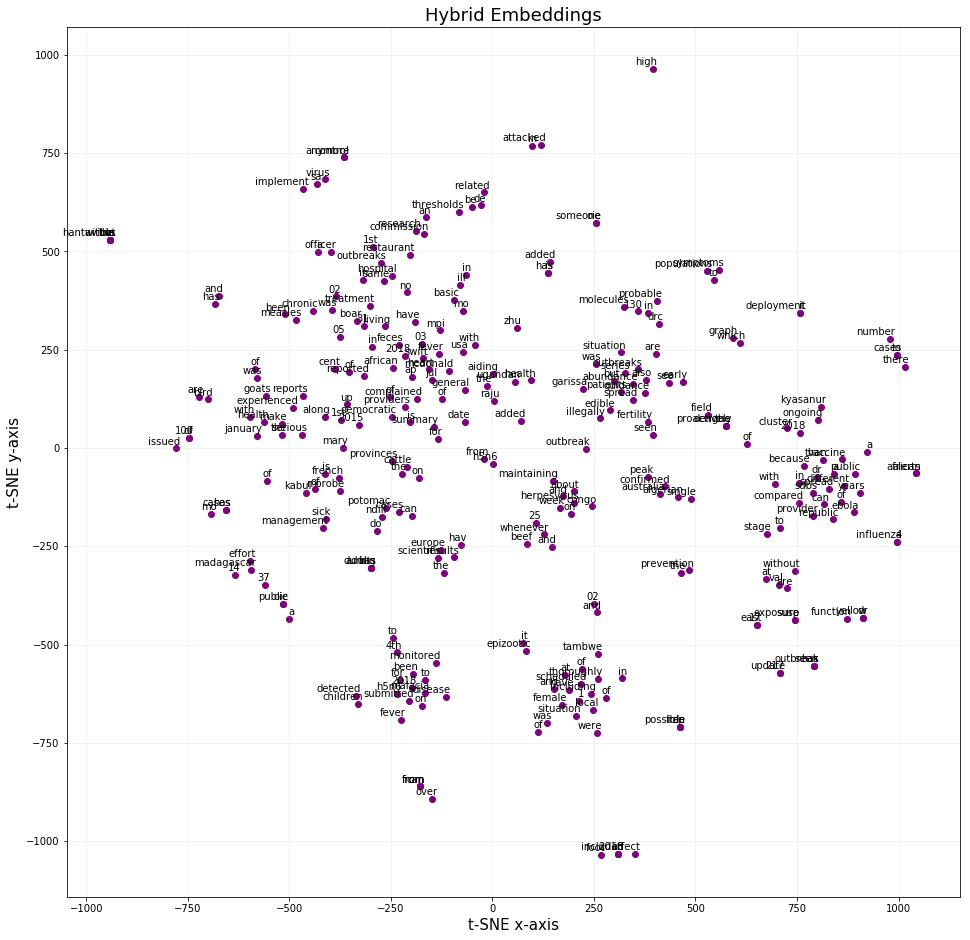

In [56]:
tsne_model_self_hybrid  = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=12)
new_values_self_hybrid  = tsne_model_self_hybrid.fit_transform(embeddings_hybrid_self_)

x_self_hybrid = []
y_self_hybrid  = []
for value in new_values_self_hybrid:
    x_self_hybrid.append(value[0])
    y_self_hybrid.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x_self_hybrid)):
    dot = plt.scatter(x_self_hybrid[i],y_self_hybrid[i], c="purple")
    plt.annotate(words_hybrid_self_[i],
                 xy=(x_self_hybrid[i], y_self_hybrid[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.xlabel("t-SNE x-axis", size=15)
plt.ylabel("t-SNE y-axis", size=15)
plt.grid(alpha=0.2)


plt.title("Hybrid Embeddings", size=18)
# plt.savefig("t-sne_self.pdf",format='pdf')
plt.show()